# Multi-ion Sideband Cooling

See J. Homes thesis for details (Entanglement of Two Trapped-Ion Spin Qubits 2006)

In [219]:
import numpy as np
from scipy.linalg import expm

import matplotlib.pyplot as plt

from tqdm import tqdm

## RSB Hamiltonians
2 ions

In [198]:
n = 10
eta = 0.18
Omega = 2*np.pi / (2*1e-6)

# 2 ion RSB Hamiltonian
def compute_Hrsb2(Omega, eta, n):
    H_rsb = 1j * eta*Omega/2 * np.array([[0, np.sqrt(n), np.sqrt(n),0],
                    [-np.sqrt(n), 0, 0, np.sqrt(n-1)],
                    [-np.sqrt(n), 0, 0, np.sqrt(n-1)],
                    [0, -np.sqrt(n-1), -np.sqrt(n-1), 0]])
    return H_rsb

H_rsb2 = compute_Hrsb2(Omega, eta, n)
np.round(H_rsb2, 3)

array([[ 0.     +0.j   ,  0.+894112.944j,  0.+894112.944j,
         0.     +0.j   ],
       [-0.-894112.944j,  0.     +0.j   ,  0.     +0.j   ,
         0.+848230.016j],
       [-0.-894112.944j,  0.     +0.j   ,  0.     +0.j   ,
         0.+848230.016j],
       [ 0.     +0.j   , -0.-848230.016j, -0.-848230.016j,
         0.     +0.j   ]])

## Time evolution
For a particular harmonic state

In [199]:
ts = np.linspace(0, 10, 200)*1e-6
start_states = [np.array([[1,0,0,0]]).T, np.array([[0,1,0,0]]).T, np.array([[0,0,1,0]]).T, np.array([[0,0,0,1]]).T]

end_state = np.array([[1,0,0,0]]).T

# H is the Hamiltonian/hbar
# Assumes start_state and end_state are column vectors. end_state will be conjugated in function
def evolve_probs(H, ts, start_state, end_state):
    probs = [np.abs((end_state.T @ expm(-1j* H * t) @ start_state)[0,0])**2 for t in ts]
    return np.array(probs)

probs = []
for state in start_states:
    probs.append(evolve_probs(H_rsb2, ts, state, end_state))


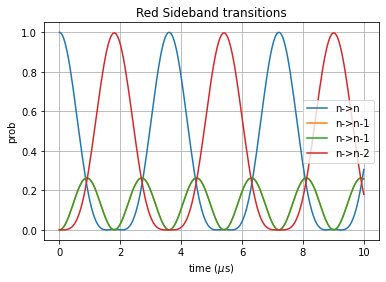

state probabilities should add to one: 1.0


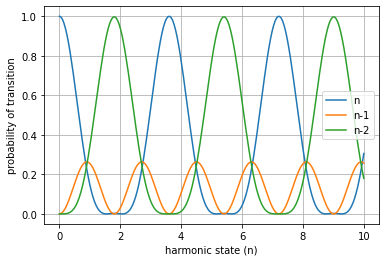

In [200]:
plt.plot(ts*1e6, np.transpose(probs))
plt.xlabel(r'time ($\mu$s)')
plt.ylabel('prob')
plt.title('Red Sideband transitions')
plt.legend(['n->n', 'n->n-1', 'n->n-1', 'n->n-2'])
plt.grid()
plt.show()

# Confirm probabilities add to 1
print('state probabilities should add to one:', np.sum(np.transpose(probs))/len(ts))

# Check against explicit equation
Gs = np.sqrt((2*n - 1)/2) * Omega * eta

prob_trans_n = (1 - n/(2*n-1)*(1-np.cos(Gs*ts)))**2
prob_trans_n_1 = n/(2*(2*n-1))*np.sin(Gs*ts)**2
prob_trans_n_2 = (np.sqrt(n*(n-1))/(2*n-1)*(1-np.cos(Gs*ts)))**2

plt.plot(ts*1e6, prob_trans_n)
plt.plot(ts*1e6, prob_trans_n_1)
plt.plot(ts*1e6, prob_trans_n_2)
plt.legend(['n', 'n-1', 'n-2'])
plt.xlabel('harmonic state (n)')
plt.ylabel('probability of transition')
plt.grid()
plt.show()

## Thermally weighted fluorescence

In [204]:
# Fluoresence on a thermally distribution pair ions (COM)
def compute_thermal_prob(ns, n_bar):
    return np.exp(ns * np.log(n_bar) - (ns+1) * np.log(n_bar + 1))

# Physical parameters
ns = np.arange(0, 300)
initial_nbar = 20
p_ns = compute_thermal_prob(ns, initial_nbar)
eta = 0.18 / np.sqrt(2)
Omega = 2*np.pi / (2*10e-6)

# Simulation parameters
ts = np.linspace(0, 50, 200)*1e-6
start_state = np.array([[1,0,0,0]]).T
end_states = [np.array([[1,0,0,0]]).T, np.array([[0,1,0,0]]).T, np.array([[0,0,1,0]]).T, np.array([[0,0,0,1]]).T]

print('harmonic population % considered in simulation', np.round(np.sum(p_ns), 7))

probs_all_states = []
# Simulate probability of evolving from down down, n (COM) to all states (down down; up down; down up; up up) weighted by a thermal distribution
probs_all_ns = np.zeros(len(ns)-1)
probs_states = []
probs_all_states = np.zeros(len(ts))
for state in tqdm(end_states):
    probs_all_ns = np.array([p_ns[n] * evolve_probs(compute_Hrsb2(Omega, eta, n), ts, start_state, state) for n in ns[1:]])
    probs_all_ns = np.sum(probs_all_ns, axis=0)  # sum over harmonic states
    probs_states.append(probs_all_ns)
    
    if state[0,0] == 1:
        probs_all_states += 0 * probs_all_ns
    elif state[1,0] == 1:
        probs_all_states += 1 * probs_all_ns
    elif state[2,0] == 1:
        probs_all_states += 1 * probs_all_ns
    elif state[3,0] == 1:
        probs_all_states += 2 * probs_all_ns



  0%|                                                    | 0/4 [00:00<?, ?it/s]

harmonic population % considered in simulation 0.9999996


100%|████████████████████████████████████████████| 4/4 [01:08<00:00, 17.24s/it]


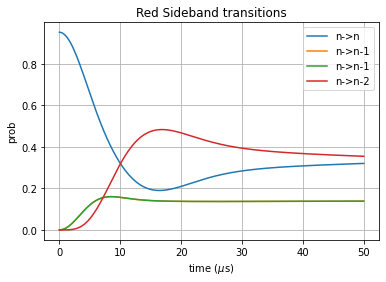

state probabilities should add to one: 0.9523805126264625
gate time for n->n-2 16.834170854271356 μs


In [205]:
plt.plot(ts*1e6, np.transpose(probs_states))
plt.xlabel(r'time ($\mu$s)')
plt.ylabel('prob')
plt.title('Red Sideband transitions')
plt.legend(['n->n', 'n->n-1', 'n->n-1', 'n->n-2'])
plt.grid()
plt.show()

# Confirm probabilities add to 1
print('state probabilities should add to one:', np.sum(np.transpose(probs_states))/len(ts))
print('gate time for n->n-2', ts[np.argmax(np.transpose(probs_states)[:,-1])]*1e6,'\u03BCs')

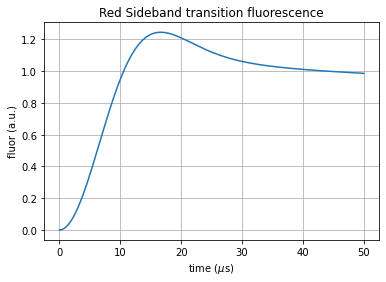

state probabilities should add to one: 0.9433824293336969


In [206]:
plt.plot(ts*1e6, probs_all_states)
plt.xlabel(r'time ($\mu$s)')
plt.ylabel('fluor (a.u.)')
plt.title('Red Sideband transition fluorescence')
plt.grid()
plt.show()

# Confirm probabilities add to 1
print('state probabilities should add to one:', np.sum(probs_all_states)/len(ts))

## RSB Hamiltonian for arbitrary number of ions

In [217]:
eta = 0.18
Omega = 2*np.pi / (2*1e-6)

# RSB Hamiltonian
def compute_Hrsb(Omega, eta, n, n_ions):
    constants = 1j * eta * Omega/2
    
    H_rsb = np.array([[0, np.sqrt(n), np.sqrt(n),0],
                    [-np.sqrt(n), 0, 0, np.sqrt(n-1)],
                    [-np.sqrt(n), 0, 0, np.sqrt(n-1)],
                    [0, -np.sqrt(n-1), -np.sqrt(n-1), 0]])
    return constants * H_rsb

H_rsb = compute_Hrsb(Omega, eta, n, 2)
np.round(H_rsb, 2)

array([[ 0.     +0.j  ,  0.+894112.94j,  0.+894112.94j,  0.     +0.j  ],
       [-0.-894112.94j,  0.     +0.j  ,  0.     +0.j  ,  0.+848230.02j],
       [-0.-894112.94j,  0.     +0.j  ,  0.     +0.j  ,  0.+848230.02j],
       [ 0.     +0.j  , -0.-848230.02j, -0.-848230.02j,  0.     +0.j  ]])

In [218]:
s_up = np.array([[0, 0], [1, 0]])
s_down = np.array([[0, 1], [0,0]])
iden = np.eye(2)

np.kron(s_up, iden), np.kron(s_down, iden), np.kron(iden, s_up), np.kron(iden, s_down)

(array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.]]),
 array([[0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
 array([[0., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 1., 0.]]),
 array([[0., 1., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 0.]]))